# Project #3

In [1]:
import sys
!{sys.executable} -m pip install yfinance
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install chart_studio
!{sys.executable} -m pip install PyPortfolioOpt

     |████████████████████████████████| 5.5MB 6.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.56-py2.py3-none-any.whl size=22627 sha256=202ceec9e14b4dc6d963982c3ed8915c12890862d8a1d1dde958295afe8b50c0
  Stored in directory: /root/.cache/pip/wheels/e9/26/69/ebde3c87490e75c5d8b06cf2dd284d1183ca1bb814b1d5f18c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 71kB 1.9MB/s 
     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 1.3MB 7.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.11-cp37-cp37m-linux_x86_64.whl size=2725529 sha256=10cfd7ee6e039aacdab5a21b18f85e22dfffa3a163f395185a4a819c936782df
  Stored in directory: /root/.cache/pip/wheels/df/d4/eb/c74e09a39bc4ac09b3a8d2a48c1c600

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, accuracy_score, silhouette_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.decomposition import PCA


from IPython.display import display, HTML, display_html
import warnings
warnings.filterwarnings('ignore')


In [3]:
# load R extension so we can use both R and Python
%load_ext rpy2.ipython

# 1. Data Importing
## 1.1 Import 11 Select Spdrs (e.g. XLF, XLE, etc.) 
Some of this period did not include the Real Estate sector fund.

In [4]:
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2020, 12, 31)
days_in_year = 252


funds = {'XLB': {'name':'Materials Select Sector SPDR ETF',               'url':'https://etfdb.com/etf/XLB/'}, 
         'XLC': {'name':'Communication Services Select Sector SPDR Fund', 'url':'https://etfdb.com/etf/XLC/'}, 
         'XLI': {'name':'Industrial Select Sector SPDR Fund',             'url':'https://etfdb.com/etf/XLI/'}, 
         'XLE': {'name':'Energy Select Sector SPDR Fund',                 'url':'https://etfdb.com/etf/XLE/'}, 
         'XLY': {'name':'Consumer Discretionary Select Sector SPDR Fund', 'url':'https://etfdb.com/etf/XLY/'}, 
         'XLP': {'name':'Consumer Staples Select Sector SPDR Fund',       'url':'https://etfdb.com/etf/XLP/'}, 
         'XLV': {'name':'Health Care Select Sector SPDR Fund',            'url':'https://etfdb.com/etf/XLV/'}, 
         'XLF': {'name':'Financial Select Sector SPDR Fund',              'url':'https://etfdb.com/etf/XLF/'}, 
         'XLK': {'name':'Technology Select Sector SPDR Fund',             'url':'https://etfdb.com/etf/XLK/'}, 
         'XLU': {'name':'Utilities Select Sector SPDR Fund',              'url':'https://etfdb.com/etf/XLU/'}, 
         'XLRE':{'name':'Real Estate Select Sector SPDR Fund',            'url':'https://etfdb.com/etf/XLRE/'}, 
         'SPY': {'name':'SPDR S&P 500 ETF',                               'url':'https://etfdb.com/etf/SPY/'}
         }

symbols = funds.keys()

data = pd.DataFrame()

for sym in symbols: 
  try: 
    fund = []
    fund = yf.download(sym, start = start_date, end = end_date, progress = True)
    if (len(fund) == 0):
        None
    else:
        fund['Name'] = sym
        data = data.append(fund, sort = False)
  except Exception:
    None


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Let's prepare our data. Fist of all remove gaps and calculate returns

In [5]:
df = data[['Adj Close', 'Name']].pivot(columns='Name') 
df.columns = df.columns.droplevel(0)
spdr_etfs = df.interpolate(method='linear') \
       .fillna(method='backfill') \
       .fillna(method='ffill')

spdr_returns = spdr_etfs.pct_change().dropna()

In [6]:
spdr_etfs

Name,SPY,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,
2019-01-02,240.242630,48.457275,41.044052,50.829411,22.839470,61.979473,60.323917,47.528236,28.099930,48.323509,81.584946,97.181541
2019-01-03,234.509766,47.083141,40.357204,50.325283,22.326008,60.093479,57.279514,47.255196,28.229805,48.314220,79.928360,95.077377
2019-01-04,242.364868,48.934402,42.093941,52.037563,23.067673,62.371994,59.818134,48.262630,28.517389,49.029644,82.312706,98.223885
2019-01-07,244.275818,49.106174,42.574738,52.811127,23.096201,62.879398,60.353088,48.196720,28.758591,48.695160,82.628700,100.444939
2019-01-08,246.570862,49.621471,43.291019,53.219639,23.115215,63.741016,60.858879,48.639236,29.259552,49.299088,83.270271,101.555481
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,366.370056,70.830887,66.073265,37.917690,28.782431,87.720016,127.939934,66.032944,35.208450,60.329521,110.765564,157.300110
2020-12-24,367.795380,71.278999,66.143143,37.719788,28.822254,87.729988,128.788132,66.361176,35.554989,60.756336,111.084457,157.629593
2020-12-28,370.955048,71.000175,67.331032,37.482311,28.961636,87.839653,130.245071,66.888321,35.842121,61.024334,111.363487,159.426727


In [7]:
import plotly as ply
import plotly.graph_objects as go
import plotly.figure_factory as ff

def dfChart(df, title = None, yAxisTitle = None, xAxisTitle = None, 
                marginTop = 60, traceType = go.Scatter, show = False): 
  chart_data = []
  for sym in df.columns:
    trace = traceType(
        x = df.index, 
        y = df[sym], 
        name = sym)
    chart_data.append(trace)
  layout = go.Layout(title = title,
                     margin = go.layout.Margin(t = marginTop, b = 30, l = 20),
                     xaxis = dict(title = xAxisTitle),
                     yaxis = dict(title = yAxisTitle), 
                     showlegend = True)
  figure = go.Figure(data = chart_data, layout = layout)
  if (show):
    ply.offline.iplot(figure)
  return(figure)

dfChart(spdr_etfs, "SPDR ETFs", yAxisTitle = "ETF Adj Closing Price")

# 2. Data Processing
## 2.1 Select 2 of the Select SPDR ETFs. Form an equally weighted portfolio of these 2 securities.

We will pick 2 securites XLF (Financial Select Sector SPDR Fund) and XLK (Technology Select Sector SPDR Fund)

In [8]:
selected_syms = ['XLF', 'XLK']
selected_funds = spdr_etfs[selected_syms]
description = pd.DataFrame(funds)[selected_syms].loc['name'].to_numpy().tolist()
name_desc = ["<b>{}</b>: {}".format(t, d) 
             for t, d in zip(selected_syms, description)]
br_sp = "<br>&nbsp;&nbsp;&nbsp;"
title = "Selected SPDR ETFs<br>" + br_sp + br_sp.join(name_desc)
dfChart(selected_funds, title, yAxisTitle = "ETF Adj Closing Price", marginTop = 50)

In [9]:
# daily returns
returns = selected_funds.pct_change().dropna()
dfChart(returns, "Daily Returns", "Pct Return")

## 2.2	Compute the standard deviation of each of the securities

In [10]:
std = pd.DataFrame({
    'Std of Returns': returns.std(),
    'Std of Adj Close Price': selected_funds.std()
})
std

,Std of Returns,Std of Adj Close Price
Name,,
XLF,0.021353,2.551071
XLK,0.019646,18.200664


## 2.3	Compute the correlation between the securities.

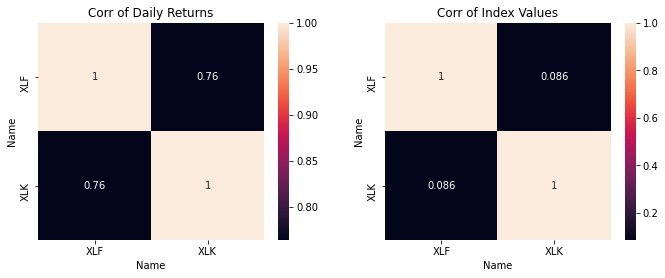

In [11]:
# daily returns correlation matrix
returnsCorrMatrix = returns.corr()

# index funds correlation matrix
fundsCorrMatrix = selected_funds.corr()

# display correlation matrixes
import seaborn as sn
fig = plt.figure(figsize = (10, 4.5))

ax1 = fig.add_subplot(121)
sn.heatmap(returnsCorrMatrix, annot = True)

ax2 = fig.add_subplot(122)
sn.heatmap(fundsCorrMatrix, annot = True)

ax1.title.set_text('Corr of Daily Returns')
ax2.title.set_text('Corr of Index Values')

plt.tight_layout(3)
plt.show()


## 2.4	Write a function that computes the weighted return of a portfolio. 

First of all we define portfolio as following structure (pyhton class)

In [13]:
class Portfolio:
  def __init__ (self, name, weights, returns, data):
    self.name = name
    self.weights = weights
    self.returns = returns
    self.symbols = returns.columns.to_list()
    self.data = data

# pretty print for Portfolio
def display_porfolio(portfolio):
    _temp = pd.DataFrame({
            'symbol': portfolio.symbols,
            'weight': portfolio.weights,
            'std_return':  portfolio.returns.std() 
            })
    display(_temp)
  

portfolio = Portfolio('Simple XLF,XLK equaly weighted',
                      [0.5, 0.5], returns, selected_funds)
display_porfolio(portfolio)

,symbol,weight,std_return
Name,,,
XLF,XLF,0.5,0.021353
XLK,XLK,0.5,0.019646


Now we can define portofolio returns functions.
To properly evaluate portfolio returns we should use geometric mean return, cause our observations are not indepnedent

In [15]:
def portfolio_weighted_returns(portfolio):
  _data = (portfolio.returns * portfolio.weights)
  _data['Portfolio Return'] = _data.sum(axis=1)
  return _data

def portfolio_return(portfolio):
  _data = portfolio_weighted_returns(portfolio)
  _data['Portfolio Return'] = _data['Portfolio Return'] + 1
  _p_returns =  stats.gmean(_data['Portfolio Return']) # compounding
  _p_returns = (_p_returns - 1) * days_in_year # annualize rate
  return _p_returns

p_returns = portfolio_return(portfolio) 
print("Portfolio '%s' return %.5f%% (annualized)" % (portfolio.name, p_returns * 100))


Portfolio 'Simple XLF,XLK equaly weighted' return 25.76805% (annualized)


## 2.5	Write a function that computes the portfolio standard deviation.

Standard deviation is the typical statistic used to measure volatility.
The volatility of two asset portfolio is calculated as:
$$
 \sigma_p = \sqrt{ \omega^2_1 \sigma^2_1 + \omega^2_2 \sigma^2_2 + 2 \omega_1 \sigma_1 \omega_2 \sigma_2 \rho_{1,2} }
$$  
where $\omega_1, \omega_2$ are weights of corresponding assets in the portfolio, $\sigma_1, \sigma_2$ - their volatilities and $\rho_{1,2}$ correlation between assert 1 and asset2.

In general form:
$$
 \sigma_p = \sqrt{ \sum_{i=1}^n \omega^2_i \sigma^2_i + \sum_{i,j=1, i\neq j}^n \omega_i \sigma_i \omega_j \sigma_j \rho_{i,j} }
$$

The python function for portfolio volatility will look like:


In [37]:
def calc_portfolio_vol(asset_weights, asset_vols, asset_corr_matrix):
  sum_1 = np.dot(asset_weights**2, asset_vols**2) # w(i)^2 * s(i)^2
  
  weighted = asset_weights * asset_vols
  weighted = weighted.reshape(len(asset_weights), 1)
  weighted_matrix = np.dot(weighted, weighted.T) # w(i)*s(i) * w(j)*s(j)
  np.fill_diagonal(weighted_matrix, 0) # i <> j

  sum_2 = np.sum(weighted_matrix * asset_corr_matrix) # w(i)*s(i) * w(j)*s(j) * corr(i,j)
  sigma = (sum_1 + sum_2)**0.5 
  sigma = sigma * ( days_in_year**0.5)  # annualize rate
  return sigma

For our porfolio we annualize volatiliy and put function as:

In [38]:
def calc_portfolio_volatility(portfolio, corr_matrix = None):
  asset_weights = np.array(portfolio.weights)
  asset_vols = portfolio.returns.std().to_numpy()
  asset_corr_matrix = portfolio.returns.corr().to_numpy() \
                     if corr_matrix is None else corr_matrix 
                     
  return calc_portfolio_vol(asset_weights, asset_vols, asset_corr_matrix)


p_volatility = calc_portfolio_volatility(portfolio)
print("Portfolio '%s' volatility is %.5f%%" % (portfolio.name, p_volatility * 100))  

Portfolio 'Simple XLF,XLK equaly weighted' volatility is 30.56583%


#3.	Category 1 Portfolio: 2 Sectors

We will pick XLF (Financial Select Sector SPDR Fund) and XLK (Technology Select Sector SPDR Fund)

## 3.1	Write a function showing the efficient frontier (EF) of your portfolio.
Be sure to vary the weights of the security from (0, 100%), (1%, 99%), … (100%, 0%).  

In [39]:
def portfolio_efficient_frontier(portfolio, corr_matrix = None):
  _df = pd.DataFrame(columns=['W1','W2', 'Return', 'Volatility'])

  for weight1 in range(101):
    weight1 = weight1 / 100 
    weight2 = 1 - weight1
    _p_name = "Weighted "
    _p_weights = [ weight1, weight2 ]
    _temp_portfolio = Portfolio(_p_name, _p_weights, 
                                portfolio.returns, portfolio.data)
    
    _p_return = portfolio_return(_temp_portfolio)
    _p_volatility = calc_portfolio_volatility(_temp_portfolio, corr_matrix)
    _df = _df.append( [{'W1': weight1, 
                        'W2': weight2,
                        'Return' : _p_return,
                        'Volatility' : _p_volatility }] )
  return _df

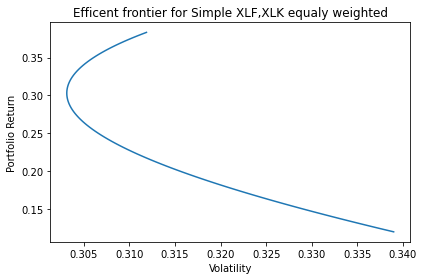

In [40]:
def plot_efficient_frontier(portfolio, alabel, corr_matrix = None, ax = None):
  p_frontier = portfolio_efficient_frontier(portfolio, corr_matrix)
  if ax is None:
    fig, ax = plt.subplots()

  ax.plot(p_frontier["Volatility"], p_frontier["Return"])
  ax.set_title(alabel)
  ax.set_ylabel("Portfolio Return")
  ax.set_xlabel("Volatility")
    
plot_efficient_frontier(portfolio, f"Efficent frontier for {portfolio.name}" )  
plt.tight_layout()  
plt.autoscale()
plt.show()

## 3.2	What is the leftmost point of the EF called?

The **leftmost** point defines the portfolio with lowest possible risk, and it is called **the global minimum variance portfolio**.

## 3.3	Rerun your function, but pretend the correlation between the securities is -1.  Graph the EF.  Comment on the shape.

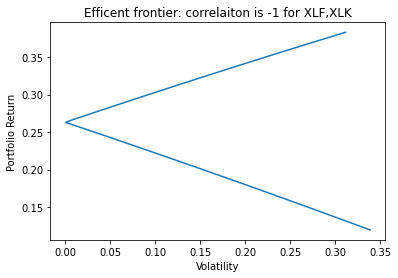

In [41]:
new_corr_matrix = np.array([ [1.0, -1.0],
                             [-1.0, 1.0] ])

plot_efficient_frontier(portfolio, 
                        "Efficent frontier: correlaiton is -1 for XLF,XLK",
                        new_corr_matrix)

A perfect negative correlation implies an inverse relationship between the changes of the two assets. Meaning one assets' gain is other assets' loss and vice-versa. This causes the inherently-quadratic (parabolic) shape of efficient frontier to become linear. Since one asset's risk is directly opposite that of the other one, there exists a proportion of them that make the total risk equal to zero.

## 3.4 Rerun your function, but pretend the correlation between the securities is 0.  Graph the EF.  Comment on the shape.

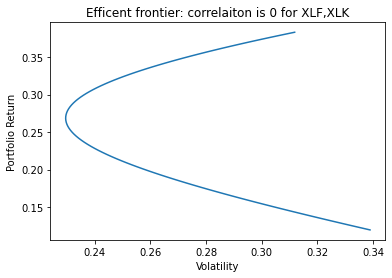

In [43]:
new_corr_matrix = np.array([ [1.0, 0],
                             [0, 1.0] ])

plot_efficient_frontier(portfolio, 
                        "Efficent frontier: correlaiton is 0 for XLF,XLK",
                        new_corr_matrix)

A correlation of zero implies that the two assets have no predictive relationship whatsoever, hence the shape is similar to that of original one, but for the same return there's more volatility (since the best-case of mutual cancellation of volatility is maximized in this case, i.e. there is no mutual cancellation of volatility). The minimal risk is not equal zero since it cant be totally cancelled out.


## 3.5 Rerun your function, but pretend the correlation between the securities is 1.  Graph the EF.  Comment on the shape.

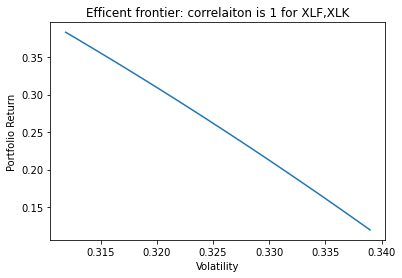

In [46]:
new_corr_matrix = np.array([ [1, 1.0],
                             [1.0, 1] ])

plot_efficient_frontier(portfolio, 
                        "Efficent frontier: correlaiton is 1 for XLF,XLK",
                        new_corr_matrix)

A correlation of 1 implies that the two assets have predictive relationship; not surprisingly this makes for a dependency that is very close to being perfectly linear; this slope of this chart is somewhat surprizing though (one would expect it to be the opposite sign)


## 3.6 Apply 5% trim to the data.  Recompute the correlation.  Rerun the EF.  

Name,XLF,XLK
Name,,
XLF,1.000000,0.764015
XLK,0.764015,1.000000


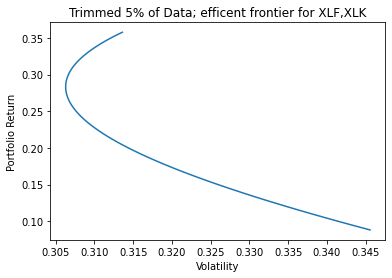

In [49]:
cut_off = 0.05
cut_off_index = (int)(len(portfolio.returns) * cut_off)
trimmed_portfolio = Portfolio('Trimmed', portfolio.weights, 
                              portfolio.returns.iloc[cut_off_index:],
                              portfolio.data.iloc[cut_off_index:])
trimmed_corr_matrix = portfolio.returns.corr()

display(trimmed_corr_matrix)
plot_efficient_frontier(trimmed_portfolio, 
                        "Trimmed 5% of Data; efficent frontier for XLF,XLK")

## 3.7 How does the EF from the actual data compare to the EF from the trimmed data?

We have trimmed first 5% of our data, which resulted in increased volatility as well as expected returns. I.e longer time intervals give us more stable and predictable results but with lower return in comparance to shorter terms.

## 3.8 Use a robust method of portfolio (see FRAPO R Library or pyportfolioopt Python module, for example).  

In [50]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import pypfopt.plotting

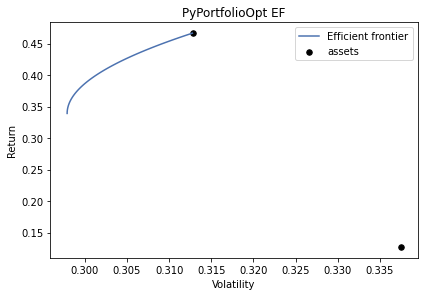

In [51]:
selected_efts = spdr_etfs[selected_syms]
mu = mean_historical_return(selected_efts)
S = CovarianceShrinkage(selected_funds).ledoit_wolf()

_frontier_pyport = EfficientFrontier(mu, S)
fig, ax = plt.subplots()
pypfopt.plotting.plot_efficient_frontier(_frontier_pyport, ax=ax, show_assets=True)
ax.set_title("PyPortfolioOpt EF")
None

## 3.9 State the equation(s) of how this works.  Write a paragraph explaining how it works.

For a given weight $w$ being the vector of the stocks having expected returns $\mu$ the portfolio return is 
$$
w^{T}\mu
$$

where the weight of eacah stock is multiplied by its respective return. The portfolio risk in the form of covariance matrix i.e. $\Sigma$ is given by $w^{T}w$.

The target return being $\mu*$, the portfolio optimization problem can then be mathematically stated as follows:
$$
minimise_{w} ( w^{T}w)
$$
subject to following 
$$
w^{T}\mu \geq  \mu^*; 
\hspace{3cm}w^{T} 1 = 1;
\hspace{3cm}w_{i} \geq 0
$$

The mean-variance portfolio optimization method works by computing a mathematically optimal combination of various assets based on different expected returns and volatilities (keyword being volatility not risk!). By varying the return we desire to target by changing the weights (thus creating different portfolios) – we obtain the so called efficient frontier (which is the set of these portfolios).This is obtained by framing the portfolio optimization as a convex optimization problem whose solution is found using quadratic programming.The line as a whole is a combination of multiple points on the axis, with each point acting as a representation of a different possible portfolio along the efficient frontier.


## 3.10 How does this EF compare with the other 2

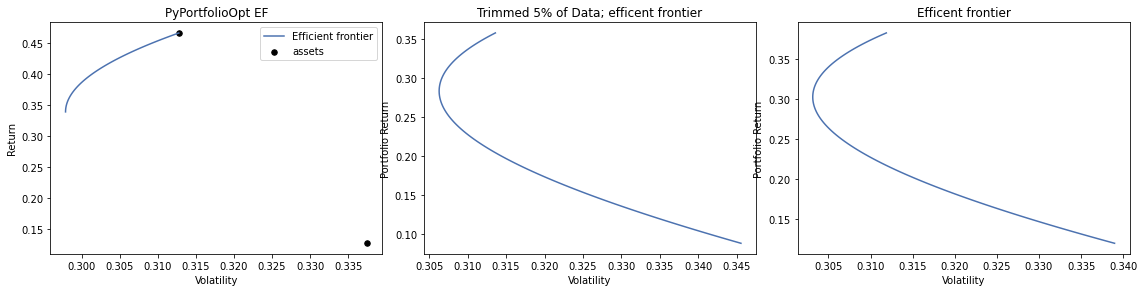

In [52]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(16, 4))

pypfopt.plotting.plot_efficient_frontier(_frontier_pyport, ax=ax1, show_assets=True)
ax1.set_title("PyPortfolioOpt EF")

plot_efficient_frontier(trimmed_portfolio, 
                        "Trimmed 5% of Data; efficent frontier", None, ax2)

plot_efficient_frontier(portfolio,
                        "Efficent frontier", None, ax3)

plt.show()

The PyPortfolioOpy generated efficient frontier gives a higher return on the global minimum variance portfolio (the left-most point on the efficient frontier), which is returns of around 0.35 for a volatility of around 0.3. The return is quite higher and the volatility is lower when compared to those of the Trimmed 5% of Data efficient frontier, and the Efficient frontier. 

The global minimum variance portfolio for the latter two (above) are returns of around 0.27 (for Trimmed 5% of data) and 0.30 (for just the Efficient frontier); with volatilities around 0.305 for both. The investor can achieve around 0.41 returns bearing a volatility of around 0.30 using PyPortfolioOpt computations.

These returns are clearly lower than that of PyPortfolioOpt, and the volatilites are quite higher than the latter. We can say that PyPortfolioOpt provides a much better global minuimum variance portfolio.

# 4. Category 2 Portfolio: 3 Sector

Addionally to XLF, XKL we will add XLI (Industrial Select Sector SPDR Fund)



## 4.1 Add 1 ETF to your portfolio.  Calculate the correlation matrix for 3 ETFs chosen.  

In [53]:
selected_sym3 = ['XLF', 'XLK', 'XLI']
etf3_returns = spdr_returns[selected_sym3]
spdr3_etfs = spdr_etfs[selected_sym3]

display(etf3_returns.corr())

portfolio3 = Portfolio('Portfolio: XLF, XLK, XLI', 
                       [0.3, 0.4, 0.3],
                       etf3_returns,
                       spdr3_etfs)


Name,XLF,XLK,XLI
Name,,,
XLF,1.000000,0.764015,0.924515
XLK,0.764015,1.000000,0.789806
XLI,0.924515,0.789806,1.000000


## 4.2 Graph the efficient frontier of this 3-security portfolio.

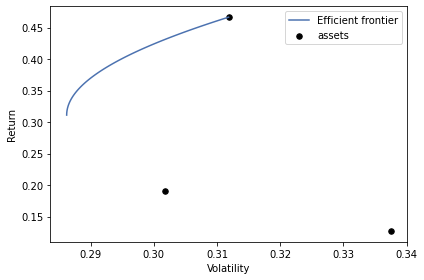

In [54]:
selected_efts = spdr_etfs[selected_sym3]
mu = mean_historical_return(selected_efts)
S = CovarianceShrinkage(selected_efts).ledoit_wolf()

_frontier = EfficientFrontier(mu, S)
fig, ax = plt.subplots()
pypfopt.plotting.plot_efficient_frontier(_frontier, ax=ax, show_assets=True)
None

## 4.3 Is there a diversification benefit to adding Security #3?  Explain your answer.

Because we have seen that PyPortfolioOpt has given reasonable results, we compare the PyPortfolioOpt efficient frontier for 2 and 3 security. 

Looking at the global minimum variance portfolio of 3 security efficient frontier, the returns are around 0.31 while volatility is around 0.29.

For the 2 security case, the returns are around 0.34 and volatility around 0.30 (of the global minimum variance portfolio). 

On first sight we might not see any benefit to diversification, however one must keep in mind that portfolio is diversified for lowering the volatility while at least attempting to keep returns reasonable, and we do accomplish this in the 3 security portfolio. 

The global minimum variance portfolio of 2 security requires investor to bear a volatility of around 0.30 while giving 0.34 in returns; the 3 security case pays around 0.40 in returns for bearing around 0.30 volatility.

Hence, there is clearly benefit of diversification.

# 5. Category 3 Portfolios:  All Combinations

## 5.1 Use 2019 daily return data.  Apply a robust method of calculating the efficient frontier for all 165 (11 choose 3) combinations of 3 Select SPDR portfolios.  DO NOT GRAPH THESE!  You are allowed to be short securities.  Call these the trained portfolios.

In [55]:
from itertools import combinations
names = spdr_etfs.columns.to_list()
names.remove('SPY')
trained_portfolios = list(combinations(names, 3))

spdr_returns_2019 = spdr_returns.loc['2019-01-01':'2019-12-31']
spdr_returns_2020 = spdr_returns.loc['2020-01-01':'2020-12-31']
spdr_etfs_2019 = spdr_etfs.loc['2019-01-01':'2019-12-31']
spdr_etfs_2020 = spdr_etfs.loc['2020-01-01':'2020-12-31']

pd.DataFrame(trained_portfolios, columns=['Asset1','Asset2','Asset3'])

,Asset1,Asset2,Asset3
0,XLB,XLC,XLE
1,XLB,XLC,XLF
2,XLB,XLC,XLI
3,XLB,XLC,XLK
4,XLB,XLC,XLP
...,...,...,...
160,XLP,XLV,XLY
161,XLRE,XLU,XLV
162,XLRE,XLU,XLY
163,XLRE,XLV,XLY


## 5.2 Assume a fixed amount of risk.  Use each portfolio's EF to determine the weights of each of the 3 securities.

In [56]:
def calc_efficient_frontier(etfs_data, trained_portfolios, target_risk):
  _df = pd.DataFrame()
  for _efts in trained_portfolios:
    _portfolio = etfs_data [ [*_efts] ]
    mu = mean_historical_return(_portfolio)
    S = CovarianceShrinkage(_portfolio).ledoit_wolf()
    frontier = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    frontier.efficient_risk(target_risk)
    weights = frontier.clean_weights()
    expectedReturn, volatility, SharpeRatio = frontier.portfolio_performance()

    _df = _df.append([{
        'Portfolio' : _portfolio.columns.to_list(),
        'Weights' : weights,
        'Expected Return': expectedReturn,
        'Volatility' : volatility,
        'SharpeRatio' : SharpeRatio,
        'Frontier' : frontier,
    }])

  return _df

portfolio_2019 = calc_efficient_frontier(spdr_etfs_2019, trained_portfolios, 0.40)
portfolio_2019[['Portfolio', 'Weights',	'Expected Return',	'Volatility', 'SharpeRatio']]

,Portfolio,Weights,Expected Return,Volatility,SharpeRatio
0,"[XLB, XLC, XLE]","{'XLB': 1.0, 'XLC': 1.0, 'XLE': -1.0}",0.434324,0.218555,1.895748
0,"[XLB, XLC, XLF]","{'XLB': -1.0, 'XLC': 1.0, 'XLF': 1.0}",0.367758,0.211920,1.640985
0,"[XLB, XLC, XLI]","{'XLB': -1.0, 'XLC': 1.0, 'XLI': 1.0}",0.344146,0.203816,1.590387
0,"[XLB, XLC, XLK]","{'XLB': -1.0, 'XLC': 1.0, 'XLK': 1.0}",0.558603,0.251958,2.137671
0,"[XLB, XLC, XLP]","{'XLB': -1.0, 'XLC': 1.0, 'XLP': 1.0}",0.341781,0.190190,1.691889
...,...,...,...,...,...
0,"[XLP, XLV, XLY]","{'XLP': 1.0, 'XLV': -1.0, 'XLY': 1.0}",0.334637,0.166377,1.891103
0,"[XLRE, XLU, XLV]","{'XLRE': 1.0, 'XLU': 1.0, 'XLV': -1.0}",0.377041,0.197594,1.806945
0,"[XLRE, XLU, XLY]","{'XLRE': 1.0, 'XLU': 1.0, 'XLY': -1.0}",0.325586,0.217999,1.401774
0,"[XLRE, XLV, XLY]","{'XLRE': 1.0, 'XLV': -1.0, 'XLY': 1.0}",0.369902,0.169331,2.066375


## 5.3 Rank the 2019 portfolio returns.

We will rank portofolio returns by Sharpe ratio as most commonly use financial metric when assessing the performance of investment management products.

The Sharpe ratio is the portfolio’s return in excess of the risk-free rate, per unit risk (volatility):

$$
Sharpe Ratio = \frac{R_p - R_f}{\sigma}
$$



In [57]:
portfolio_2019.sort_values(by=['SharpeRatio'], ascending=False)\
 [['Weights',	'SharpeRatio', 'Expected Return',	'Volatility']]

,Weights,SharpeRatio,Expected Return,Volatility
0,"{'XLK': 1.0, 'XLU': 1.0, 'XLV': -1.0}",3.199872,0.558598,0.168319
0,"{'XLK': 1.0, 'XLRE': 1.0, 'XLY': -1.0}",3.154681,0.542976,0.165778
0,"{'XLK': 1.0, 'XLP': 1.0, 'XLY': -1.0}",3.107518,0.507711,0.156946
0,"{'XLK': 1.0, 'XLU': 1.0, 'XLY': -1.0}",3.084062,0.507143,0.157955
0,"{'XLK': 1.0, 'XLRE': 1.0, 'XLV': -1.0}",3.083273,0.594431,0.186306
...,...,...,...,...
0,"{'XLF': 1.0, 'XLI': 1.0, 'XLP': -1.0}",1.132862,0.311523,0.257333
0,"{'XLC': 1.0, 'XLI': 1.0, 'XLP': -1.0}",1.113970,0.296938,0.248605
0,"{'XLC': 1.0, 'XLF': 1.0, 'XLU': -1.0}",1.036781,0.321118,0.290436
0,"{'XLF': 1.0, 'XLI': 1.0, 'XLU': -1.0}",0.957258,0.312092,0.305134


## 5.4 Test each of the 165 portfolios using 2020 daily return data.  

In [58]:
portfolio_2020 = calc_efficient_frontier(spdr_etfs_2020, trained_portfolios, 0.40)
portfolio_2020[['Portfolio', 'Weights',	'SharpeRatio', 'Expected Return',	'Volatility']]

,Portfolio,Weights,SharpeRatio,Expected Return,Volatility
0,"[XLB, XLC, XLE]","{'XLB': 0.98177, 'XLC': 0.78111, 'XLE': -0.76289}",1.582963,0.653185,0.400000
0,"[XLB, XLC, XLF]","{'XLB': 1.0, 'XLC': 1.0, 'XLF': -1.0}",1.293540,0.499359,0.370579
0,"[XLB, XLC, XLI]","{'XLB': 1.0, 'XLC': 1.0, 'XLI': -1.0}",0.938997,0.376694,0.379867
0,"[XLB, XLC, XLK]","{'XLB': -0.11833, 'XLC': 0.13091, 'XLK': 0.98743}",0.977772,0.411109,0.400000
0,"[XLB, XLC, XLP]","{'XLB': 0.56468, 'XLC': 1.0, 'XLP': -0.56468}",0.722217,0.308887,0.400000
...,...,...,...,...,...
0,"[XLP, XLV, XLY]","{'XLP': -0.90855, 'XLV': 0.90855, 'XLY': 1.0}",0.690613,0.296245,0.400000
0,"[XLRE, XLU, XLV]","{'XLRE': -1.0, 'XLU': 1.0, 'XLV': 1.0}",0.331337,0.143986,0.374200
0,"[XLRE, XLU, XLY]","{'XLRE': -1.0, 'XLU': 1.0, 'XLY': 1.0}",0.760823,0.306913,0.377108
0,"[XLRE, XLV, XLY]","{'XLRE': -1.0, 'XLV': 1.0, 'XLY': 1.0}",1.129646,0.422674,0.356460


## 5.5 Rank the 2020 portfolio returns.

Again we will use Sharpe Ratio to rank portfolio returns

In [59]:
portfolio_2020.sort_values(by=['SharpeRatio'], ascending=False)\
 [['Weights', 'SharpeRatio', 'Expected Return',	'Volatility']]

,Weights,SharpeRatio,Expected Return,Volatility
0,"{'XLB': 0.77311, 'XLE': -0.77311, 'XLY': 1.0}",1.704079,0.701632,0.4
0,"{'XLE': -0.52027, 'XLK': 0.52027, 'XLY': 1.0}",1.613622,0.665449,0.4
0,"{'XLC': 0.65436, 'XLE': -0.65436, 'XLY': 1.0}",1.592259,0.656904,0.4
0,"{'XLB': 0.98177, 'XLC': 0.78111, 'XLE': -0.76289}",1.582963,0.653185,0.4
0,"{'XLB': 0.85502, 'XLE': -0.52754, 'XLK': 0.67251}",1.531244,0.632498,0.4
...,...,...,...,...
0,"{'XLE': -0.36994, 'XLF': 0.61008, 'XLU': 0.75986}",0.199767,0.099907,0.4
0,"{'XLF': -0.84413, 'XLI': 1.0, 'XLRE': 0.84413}",0.194355,0.097742,0.4
0,"{'XLE': -0.28555, 'XLRE': 0.59701, 'XLU': 0.68...",0.155965,0.082386,0.4
0,"{'XLE': -0.15689, 'XLF': 0.38432, 'XLRE': 0.77...",-0.001809,0.019277,0.4


#6. Analyzing 3-Security Portfolio

Recall from the previous assignment, you assigned each ETF to 1 of 3 groups: Leading, Coincidental, or Lagging Economic Indicators.  

## 6.1 Relabel the ETF with a + sign if the weight >0, or a - sign if the weight <0.  Then add the assigned Economic Indicator.

For example, if a portfolio were long XLRE, and XLRE was a LEI, then XLRE -> +LEI.  

For example, if a portfolio were short XLF, and XLF was a LAG, then XLF -> -LAG.  

Do this for each security in each portfolio.

## 6.2 Using the ranks from 5.5, determine which combinations tend to be the best performing.  Interpret the results.

Let us graphically evaluate the ranks from 5.5 for a more visual perspective

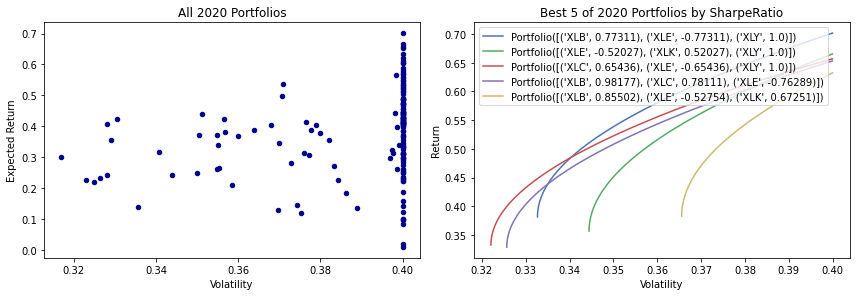

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
Rank2020 = portfolio_2020.sort_values(by=['SharpeRatio'], ascending=False)
Rank2020.plot.scatter(x='Volatility',y='Expected Return',c='DarkBlue', ax=ax1)

NUM_OF_BEST_PORTFOLIOS = 5
for index in range(NUM_OF_BEST_PORTFOLIOS):
  frontier = Rank2020.iloc[index]['Frontier']
  pypfopt.plotting.plot_efficient_frontier(frontier, ax=ax2, show_assets=False)

# fix legend labels
legend = ax2.legend()
for index in range(NUM_OF_BEST_PORTFOLIOS):
  weights = Rank2020.iloc[index]['Weights']
  weights_str = str(weights).replace('OrderedDict','Portfolio')
  legend.get_texts()[index].set_text(weights_str)  

ax1.set_title("All 2020 Portfolios")  
ax2.set_title("Best %d of 2020 Portfolios by SharpeRatio" % NUM_OF_BEST_PORTFOLIOS )
None

In [61]:
Rank2020[['Portfolio','SharpeRatio', 'Weights',	'Expected Return',	'Volatility']]

,Portfolio,SharpeRatio,Weights,Expected Return,Volatility
0,"[XLB, XLE, XLY]",1.704079,"{'XLB': 0.77311, 'XLE': -0.77311, 'XLY': 1.0}",0.701632,0.4
0,"[XLE, XLK, XLY]",1.613622,"{'XLE': -0.52027, 'XLK': 0.52027, 'XLY': 1.0}",0.665449,0.4
0,"[XLC, XLE, XLY]",1.592259,"{'XLC': 0.65436, 'XLE': -0.65436, 'XLY': 1.0}",0.656904,0.4
0,"[XLB, XLC, XLE]",1.582963,"{'XLB': 0.98177, 'XLC': 0.78111, 'XLE': -0.76289}",0.653185,0.4
0,"[XLB, XLE, XLK]",1.531244,"{'XLB': 0.85502, 'XLE': -0.52754, 'XLK': 0.67251}",0.632498,0.4
...,...,...,...,...,...
0,"[XLE, XLF, XLU]",0.199767,"{'XLE': -0.36994, 'XLF': 0.61008, 'XLU': 0.75986}",0.099907,0.4
0,"[XLF, XLI, XLRE]",0.194355,"{'XLF': -0.84413, 'XLI': 1.0, 'XLRE': 0.84413}",0.097742,0.4
0,"[XLE, XLRE, XLU]",0.155965,"{'XLE': -0.28555, 'XLRE': 0.59701, 'XLU': 0.68...",0.082386,0.4
0,"[XLE, XLF, XLRE]",-0.001809,"{'XLE': -0.15689, 'XLF': 0.38432, 'XLRE': 0.77...",0.019277,0.4


In our ranking, the range of volatility varies from around 0.32 to 0.40. For a volatility of 0.40, the returns range from as low as around 0.1 to as high as 0.7. 

Without considering the effects of weight distribution on our portfolio and solely looking from a risk-return Markowitz'ian framework; we can see that around 0.55 and around 0.7 are the highest returns in our set of combinations. However, for 0.7 the volatility is 0.4, while for 0.55 the volatility is 0.375. 

From a risk-return perspective, we can see it was a bull market with a strong trend.



# 7. Category 4 Portfolios: Using Principal Components

## 7.1 Compute the PCA from the correlation matrix of the 11 ETFs.

Using the correlation matrix is equivalent to standardizing each of the variables (to mean 0 and standard deviation 1). In general, PCA with and without standardizing will give different results. Especially when the scales are different.

In [62]:
spdr_etfs_pca =  spdr_etfs.drop(columns=['SPY'])
spdr_etfs_2019_pca = spdr_etfs_2019.drop(columns=['SPY'])
spdr_etfs_2020_pca = spdr_etfs_2020.drop(columns=['SPY'])

In [63]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(spdr_etfs_2019_pca)

pca = PCA(n_components=3)
pca_components = pca.fit_transform(x)
X = pd.DataFrame(data = pca_components,
             columns = ['p1', 'p2', 'p3'],
             index = spdr_etfs_2019_pca.index)
X

,p1,p2,p3
Date,,,
2019-01-02,7.749746,1.726363,-1.514340
2019-01-03,8.630146,2.306830,-1.362017
2019-01-04,7.250117,1.313196,-1.290216
2019-01-07,6.982498,0.966141,-1.048703
2019-01-08,6.474916,0.801386,-0.903152
...,...,...,...
2019-12-24,-5.495923,-1.553571,-1.271280
2019-12-26,-5.781844,-1.573183,-1.147657
2019-12-27,-5.788771,-1.422819,-1.152779


## 7.2 Using 2019 data, compute the EF for the first 3 principal components portfolio.

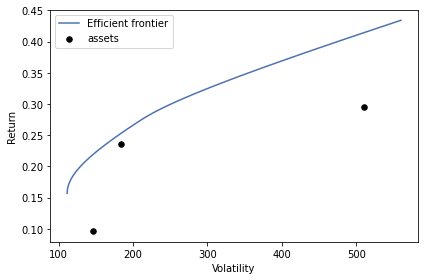

In [64]:
mu = mean_historical_return(spdr_etfs_2019_pca[['XLB', 'XLC', 'XLE']])
S = CovarianceShrinkage(X).shrunk_covariance()
frontier = EfficientFrontier(mu, S, weight_bounds=(-1,1))

fig, ax = plt.subplots()
pypfopt.plotting.plot_efficient_frontier(frontier, ax=ax, show_assets=True)
None

## 7.3 How does the PCA portfolio return compare to the 2019  3-security portfolio returns?

PCA Returns are lower than in 2019 Portfolio of 3 securities, but PCA got enormous volatility. This happens due to PCA algorith which picks the most volatile components as principal components and projects other components on chosen eigen vectors(securities). 

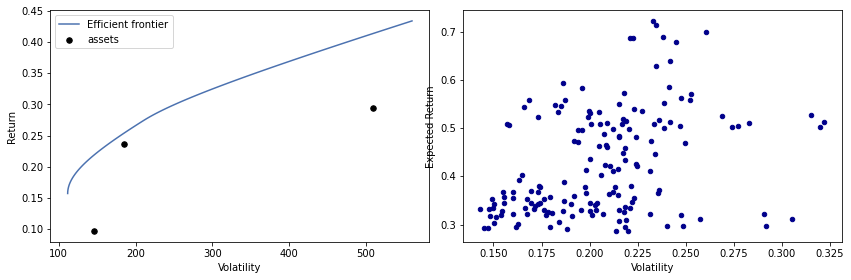

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
pypfopt.plotting.plot_efficient_frontier(frontier, ax=ax1, show_assets=True)

R2019 = portfolio_2019.sort_values(by=['SharpeRatio'])
R2019.plot.scatter(x='Volatility',y='Expected Return',c='DarkBlue', ax=ax2)
None

## 7.4 Assuming a fixed amount of risk, and 2020 data, use the PC weights to compute the 3-PC portfolio returns.

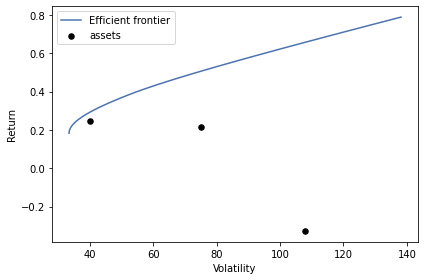

In [66]:
x = StandardScaler().fit_transform(spdr_etfs_2020_pca)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(x)
X = pd.DataFrame(data = pca_components,
             columns = ['p1', 'p2', 'p3'],
             index = spdr_etfs_2020_pca.index)

mu = mean_historical_return(spdr_etfs_2020_pca[['XLB', 'XLC', 'XLE']])
S = CovarianceShrinkage(X).shrunk_covariance()
frontier = EfficientFrontier(mu, S, weight_bounds=(-1,1))

fig, ax = plt.subplots()
pypfopt.plotting.plot_efficient_frontier(frontier, ax=ax, show_assets=True)
None

## 7.5 How does the PCA portfolio return compare to the 2020  3-security portfolio returns?

PCA Returns are much higher than 2020 Portfolio of 3 securities, as consequence enormous volatility. This happens due to PCA algorith which picks the most volatile components as principal components and projects other components on chosen eigen vectors(securities). 

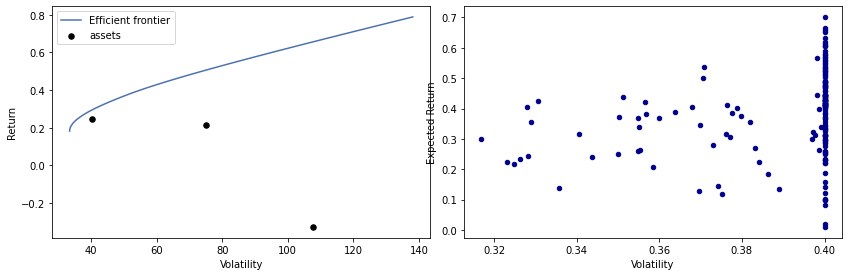

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
pypfopt.plotting.plot_efficient_frontier(frontier, ax=ax1, show_assets=True)

Rank2020.plot.scatter(x='Volatility',y='Expected Return',c='DarkBlue', ax=ax2)
None

***Please find section 8 in a separate document***

# References


1. West G. (2006) An Introduction to Modern Portfolio Theory: Markowitz, CAP-M,
APT and Black-Litterman. Financial Modelling Agency.
http://www.finmod.co.za/MPT.pdf. (2012-11-07)
2. Sharpe W.F (Fall 1994) The Sharpe Ratio, Stanford University,re-print
 The Journal of Portfolio Management. http://web.stanford.edu/~wfsharpe/art/sr/SR.htm
3. Ganti A. (2021) Efficient Frontier, Investopedia. https://www.investopedia.com/terms/e/efficientfrontier.asp#:~:text=The%20efficient%20frontier%20is%20the,for%20the%20level%20of%20risk.
